In [1]:
import pandas as pd
from glob import glob
import numpy as np

import sys
sys.path.append("../scripts/") # go to parent dir

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from read_data import fromcsv2df, distribution, filtering, distribution_weights
from metrics import significance, significance_with_weight, prediction, significance_true_values
from plots import plot_scores_v2, plot_scores
from classification import classification_RF_with_tunning


In [2]:
source_path = "../processed_data/"

def run(signal_file,signal, category="mumuOS"):
    new_l = []
    # read CSV file containing a particular signal plus all the background
    df0 = fromcsv2df(signal_file) 
    print("Original variables", df0.columns)
    print("Num. rows (events):", df0.shape[0])
    print("Num. variables:", df0.shape[1])
    
    # getting the event weights 
    weights0 = df0['weight_column']
    
    # selecting features (by expert decision) plus label
    df = df0[['bveto', 'mt2t','nfj_w','hthad_fj','mt', 'met', 'htlep','label']]
    #display(df0)
    
    # data and label matrices
    y = df["label"]
    X = df.drop(columns=["label"])
    print("-------------")
    X,y, weights = filtering(df0,X,y,weights0, category)
    print("::: Filtered data :::")
    print("Num rows:", X.shape[0])
    print("Num variables:", X.shape[1])
    #display(X.head())
    
    # only features
    cols = ['bveto', 'mt2t','nfj_w','hthad_fj','mt', 'met', 'htlep']
    
    # Normalization
    X= (X-X.min())/(X.max()-X.min())
    X_temp = X.join(weights)
    
    
    # training, validation, and testing data
    X_train, X_test, y_train, y_test   = train_test_split(X_temp, y, test_size=0.2,random_state=1)
    #print("X_train.head()")
    #display(X_train.head())
    #print("X_test.head()")
    #display(X_test.head())
    
    train_w = X_train["weight_column"]
    test_w = X_test["weight_column"]
    
    X_test =X_test[cols]
    X_train =X_train[cols]

    # show distributions per classes
    dict_labels = {"y_train":y_train,"y_test": y_test}
    dict_weights = {"y_train": train_w, "y_test": test_w}
    
    
    
    df_distro_weights = distribution_weights(dict_labels, dict_weights)
    display(df_distro_weights)
    
    new_dict={}
    new_dict["signal"] = signal
    b_ = df_distro_weights["#background"].sum()
    new_dict["#back"] = b_
    s_ = df_distro_weights["#signal"].sum()
    new_dict["#sig"] = s_
    new_dict["%b"] = 100* (b_/(s_+b_))
    new_dict["%s"] = 100* (s_/(s_+b_))
    new_dict["tot. events"] = s_+ b_
    
    w_s = df_distro_weights["w_s"].sum()
    w_b = df_distro_weights["w_b"].sum()
    new_dict["w_s"] = w_s
    new_dict["w_b"] = w_b
    new_dict["%w_s"] = 100*(w_s/(w_s+w_b))
    new_dict["%w_b"] = 100*(w_b/(w_s+w_b))
    
    new_l.append(new_dict)
    SIGNIF = significance_true_values(y.values,y.values,weights.values)
    new_dict["SIGNIF_TRUE"] = SIGNIF
    
    
    # classification model using RandomForest
    clf = classification_RF_with_tunning(X_train, y_train,train_w)
    
    print("\n::: TRAIN PREDICTION :::\n")
    y_pred_train = clf.predict(X_train)
    y_pred_score_train = clf.predict_proba(X_train)
    metrics_train = prediction(y_train,  y_pred_score_train[:,1], title= "train", weights= train_w)
    
    print("\n::: TEST PREDICTION :::\n")
    y_pred=clf.predict(X_test)
    y_pred_score = clf.predict_proba(X_test) #1 - clf.predict_proba(X_test)[:,1] #!!!!!!!
    metrics = prediction(y_test, y_pred_score[:,1],title="testing",weights=test_w)
    
    
    mask_sig, mask_back, mask_sig_train, mask_back_train = plot_scores(y_pred_score[:,1], y_test,y_pred_score_train[:,1], y_train)
    plot_scores_v2(y_pred_score[:,1], mask_sig,mask_back,y_pred_score_train[:,1], mask_sig_train, mask_back_train, metrics, metrics_train, category,signal)

    
    print("classification_report TEST ::::")
    cr_test_w = classification_report(y_test, y_pred, sample_weight=test_w)
    cr_test = classification_report(y_test, y_pred)
    print(cr_test_w)
    print(cr_test)
    

    print("classification_report TRAIN ::::")
    cr_train_w =classification_report(y_train, y_pred_train, sample_weight=train_w)
    cr_train =classification_report(y_train, y_pred_train)
    print(cr_train_w)
    print(cr_train)
    

    
    return metrics, mask_sig, mask_back, y_pred, y_test, y_pred_score, y_pred_train, y_pred_score_train,mask_sig_train, mask_back_train, new_l
    

************************************************************
************************************************************
************************************************************
File: all_signal_m800_np_bg.csv
m800_np
Original variables Index(['mumuSS', 'mumuOS', 'emu', 'ee', 'mll', 'drll', 'drjl1', 'drjl2',
       'drlmet', 'dphi_ll', 'dphi_llmet', 'dphi_fj12', 'dphi_fj13',
       'dphi_fj23', 'met', 'mt', 'mt2t', 'bveto', 'hthad_rj', 'hthad_fj',
       'htlep', 'fj1mass', 'fj2mass', 'fj1pt', 'fj2pt', 'nel', 'nmu', 'nj',
       'nfj', 'nfj_w', 'label', 'weight_column', 'sample'],
      dtype='object')
Num. rows (events): 308113
Num. variables: 33
-------------
Category: mumuSS
::: Filtered data :::
Num rows: 4094
Num variables: 7
::: TP signal 11.996400000000001
::::::::::b 1283.917915620434
::: TP signal 3.2292000000000005
::::::::::b 295.81345898313424


,data,#background,#signal,% b,% s,total,w_s,w_b,%w_s,%w_b,w_total,SIGNIF_WEIGHT,SIGNIF_TRUE
0,train,1737,1538,53.038168,46.961832,3275,11.9964,1283.917916,0.925709,99.074291,1295.914316,0.334278,0.334278
1,test,405,414,49.450549,50.549451,819,3.2292,295.813459,1.079846,98.920154,299.042659,0.187413,0.187413


::: TP signal 15.2256
::::::::::b 1579.7313746035684
Running classification model ...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.0s finished


clf.classes_ [0 1]
1.255702018737793

::: TRAIN PREDICTION :::

::: TP signal 11.973
::::::::::b 1283.2254041918627
Significance ::::: 0.3337169318388296
yes 0.3337169318388296
::: TP signal 11.973
::::::::::b 1283.787158477577
Significance ::::: 0.33364413624023387
::: TP signal 11.902800000000001
::::::::::b 1283.8917641918626
Significance ::::: 0.3316774497326748
::: TP signal 11.7702
::::::::::b 1283.917915620434
Significance ::::: 0.3279847657690965
::: TP signal 11.5674
::::::::::b 1283.917915620434
Significance ::::: 0.3223420381692607
::: TP signal 11.2242
::::::::::b 1283.917915620434
Significance ::::: 0.31279213552288626
::: TP signal 10.7562
::::::::::b 1283.917915620434
Significance ::::: 0.29976818047437626
::: TP signal 9.999600000000001
::::::::::b 1283.917915620434
Significance ::::: 0.2787094643683736
::: TP signal 8.892000000000001
::::::::::b 1283.917915620434
Significance ::::: 0.24787383186511436
::: TP signal 7.1838
::::::::::b 1283.917915620434
Significance ::::

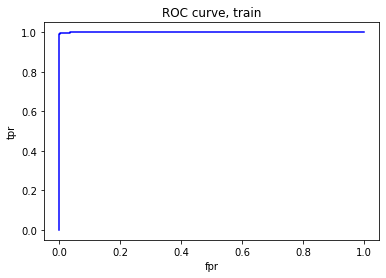

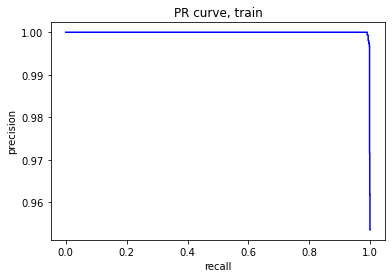

f1: 0.99 prec: 0.99 rec: 1.0 acc: 0.99 roc_auc 0.9999206440112804
[[1723   14]
 [   3 1535]]

::: TEST PREDICTION :::

::: TP signal 3.0576
::::::::::b 140.60852511198658
Significance ::::: 0.25692841447400966
yes 0.25692841447400966
::: TP signal 2.9016
::::::::::b 184.1490420556965
Significance ::::: 0.21326433740998915
::: TP signal 2.7612
::::::::::b 209.50103812872115
Significance ::::: 0.19035090509741434
::: TP signal 2.652
::::::::::b 226.55538212199764
Significance ::::: 0.17584998029368673
::: TP signal 2.4492000000000003
::::::::::b 242.6702034971393
Significance ::::: 0.15695961832736235
::: TP signal 2.1996
::::::::::b 251.52784489170995
Significance ::::: 0.1384903561147021
::: TP signal 1.9266000000000003
::::::::::b 261.1438648577092
Significance ::::: 0.11907454926895071
::: TP signal 1.5834000000000001
::::::::::b 275.4155076419933
Significance ::::: 0.09531935713236936
::: TP signal 1.2714
::::::::::b 283.47005760799254
Significance ::::: 0.07545785417568038
::: TP s

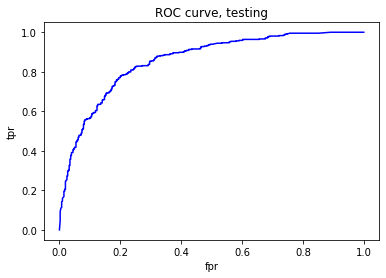

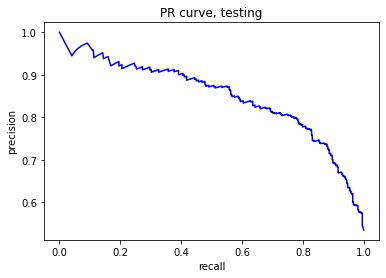

f1: 0.76 prec: 0.64 rec: 0.95 acc: 0.7 roc_auc 0.8571360410329815
[[185 220]
 [ 22 392]]
[189.  43.  33.  21.  19.  20.  10.  13.   9.  18.   8.   8.   4.   8.
   2.] 
 [23. 15. 10. 19.  7. 21. 22. 30. 20. 44. 20. 45. 33. 60. 45.]


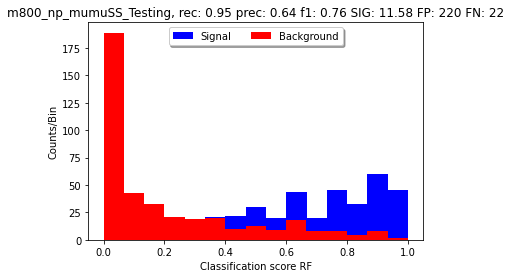

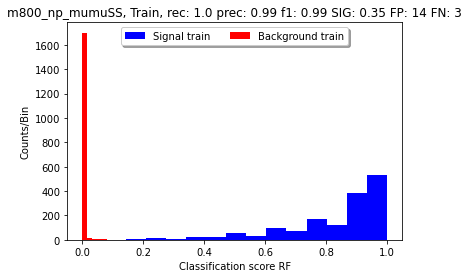

classification_report TEST ::::
              precision    recall  f1-score   support

           0       1.00      0.85      0.92 295.8134589831353
           1       0.05      0.68      0.09 3.2292000000000094

    accuracy                           0.85 299.0426589831353
   macro avg       0.52      0.77      0.50 299.0426589831353
weighted avg       0.99      0.85      0.91 299.0426589831353

              precision    recall  f1-score   support

           0       0.72      0.85      0.78       405
           1       0.82      0.68      0.74       414

    accuracy                           0.76       819
   macro avg       0.77      0.76      0.76       819
weighted avg       0.77      0.76      0.76       819

classification_report TRAIN ::::
              precision    recall  f1-score   support

           0       1.00      1.00      1.00 1283.9179156204448
           1       1.00      0.94      0.97 11.996399999999587

    accuracy                           1.00 1295.914315620

,data,#background,#signal,% b,% s,total,w_s,w_b,%w_s,%w_b,w_total,SIGNIF_WEIGHT,SIGNIF_TRUE
0,train,1725,915,65.340909,34.659091,2640,79.605,1273.762881,5.881993,94.118007,1353.367881,2.207821,2.207821
1,test,417,243,63.181818,36.818182,660,21.141,305.968494,6.462974,93.537026,327.109494,1.195081,1.195081


::: TP signal 100.74599999999998
::::::::::b 1579.7313746035684
Running classification model ...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    1.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.3s finished


clf.classes_ [0 1]
1.5757060050964355

::: TRAIN PREDICTION :::

::: TP signal 79.60499999999999
::::::::::b 1214.7957678167563
Significance ::::: 2.2596740366245345
yes 2.2596740366245345
::: TP signal 79.60499999999999
::::::::::b 1270.2777549013263
Significance ::::: 2.210786548236755
::: TP signal 79.60499999999999
::::::::::b 1272.854870615612
Significance ::::: 2.2085921976422282
::: TP signal 78.73499999999999
::::::::::b 1273.4971749013264
Significance ::::: 2.1841534891022123
::: TP signal 76.90799999999997
::::::::::b 1273.6300277584692
Significance ::::: 2.133852654656322
::: TP signal 72.90599999999998
::::::::::b 1273.7105777584693
Significance ::::: 2.023772110741968
::: TP signal 65.68499999999997
::::::::::b 1273.7628806156122
Significance ::::: 1.8249536451949786
::: TP signal 55.24499999999998
::::::::::b 1273.7628806156122
Significance ::::: 1.5369288251156203
::: TP signal 40.62899999999999
::::::::::b 1273.7628806156122
Significance ::::: 1.132419199919511
::: TP s

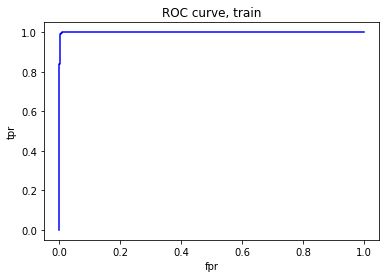

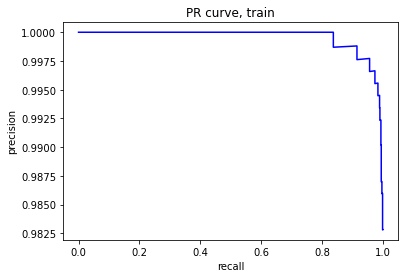

f1: 0.92 prec: 0.84 rec: 1.0 acc: 0.94 roc_auc 0.9997731844460284
[[1556  169]
 [   0  915]]

::: TEST PREDICTION :::

::: TP signal 20.444999999999993
::::::::::b 59.1629692791214
Significance ::::: 2.5235325444656738
yes 2.5235325444656738
::: TP signal 17.312999999999995
::::::::::b 143.25965466311402
Significance ::::: 1.418714586714927
::: TP signal 14.963999999999995
::::::::::b 192.46984160682393
Significance ::::: 1.0650724008689438
::: TP signal 12.353999999999996
::::::::::b 227.8215671753921
Significance ::::: 0.8112489881499141
::: TP signal 9.917999999999997
::::::::::b 252.72355135424684
Significance ::::: 0.6198649337415976
::: TP signal 6.872999999999997
::::::::::b 270.3976355671024
Significance ::::: 0.41621762137299195
::: TP signal 4.7849999999999975
::::::::::b 282.35683123767285
Significance ::::: 0.2839638288265256
::: TP signal 2.871
::::::::::b 295.14816261281453
Significance ::::: 0.16684428511850546
::: TP signal 1.6529999999999998
::::::::::b 302.03643257881

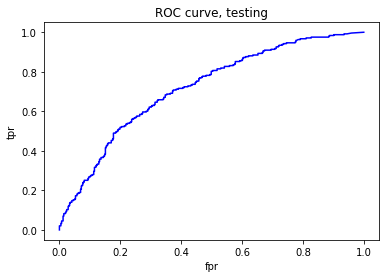

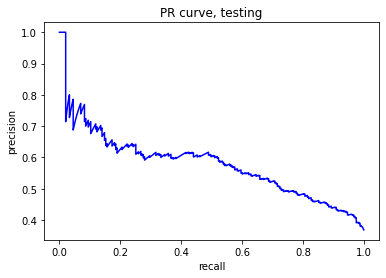

f1: 0.58 prec: 0.41 rec: 0.97 acc: 0.48 roc_auc 0.7176925126565415
[[ 80 337]
 [  8 235]]
[101.  69.  46.  49.  29.  28.  21.  17.  10.  15.  11.   9.   6.   3.
   3.] 
 [15. 24. 21. 23. 18. 18. 31. 21. 11. 22. 13.  7.  9.  6.  4.]


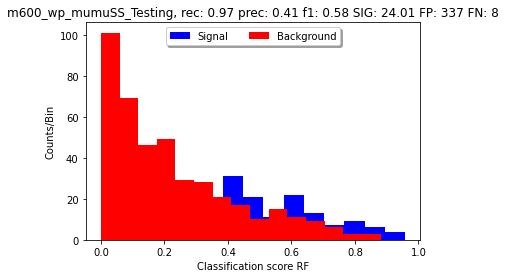

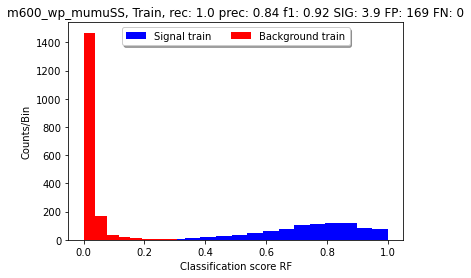

classification_report TEST ::::
              precision    recall  f1-score   support

           0       0.95      0.88      0.92 305.9684939879573
           1       0.16      0.33      0.22 21.140999999999956

    accuracy                           0.85 327.10949398795725
   macro avg       0.56      0.60      0.57 327.10949398795725
weighted avg       0.90      0.85      0.87 327.10949398795725

              precision    recall  f1-score   support

           0       0.69      0.88      0.77       417
           1       0.61      0.33      0.42       243

    accuracy                           0.68       660
   macro avg       0.65      0.60      0.60       660
weighted avg       0.66      0.68      0.65       660

classification_report TRAIN ::::
              precision    recall  f1-score   support

           0       0.99      1.00      1.00 1273.7628806156215
           1       1.00      0.92      0.96 79.60500000000172

    accuracy                           1.00 1353.3678806

,data,#background,#signal,% b,% s,total,w_s,w_b,%w_s,%w_b,w_total,SIGNIF_WEIGHT,SIGNIF_TRUE
0,train,1705,1719,49.795561,50.204439,3424,17.5338,1257.640406,1.375012,98.624988,1275.174206,0.493280,0.493280
1,test,437,420,50.991832,49.008168,857,4.2840,322.090969,1.312601,98.687399,326.374969,0.238178,0.238178


::: TP signal 21.8178
::::::::::b 1579.7313746035684
Running classification model ...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.8s finished


clf.classes_ [0 1]
1.049072027206421

::: TRAIN PREDICTION :::

::: TP signal 17.5236
::::::::::b 1256.706244532873
Significance ::::: 0.4931758450283094
yes 0.4931758450283094
::: TP signal 17.493
::::::::::b 1257.5619516757301
Significance ::::: 0.4921498758089684
::: TP signal 17.4318
::::::::::b 1257.5881031043014
Significance ::::: 0.4904269341469016
::: TP signal 17.3298
::::::::::b 1257.6404059614442
Significance ::::: 0.48755370055023634
::: TP signal 16.9728
::::::::::b 1257.6404059614442
Significance ::::: 0.4775323107786462
::: TP signal 16.6158
::::::::::b 1257.6404059614442
Significance ::::: 0.4675099843054493
::: TP signal 15.932400000000001
::::::::::b 1257.6404059614442
Significance ::::: 0.44832177389620437
::: TP signal 15.147000000000002
::::::::::b 1257.6404059614442
Significance ::::: 0.42626540776801103
::: TP signal 13.7394
::::::::::b 1257.6404059614442
Significance ::::: 0.38672445020627666
::: TP signal 11.7402
::::::::::b 1257.6404059614442
Significance ::::

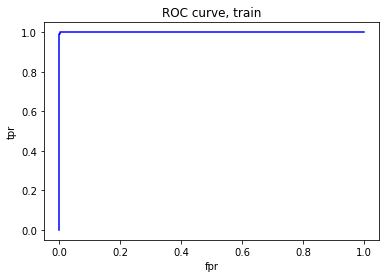

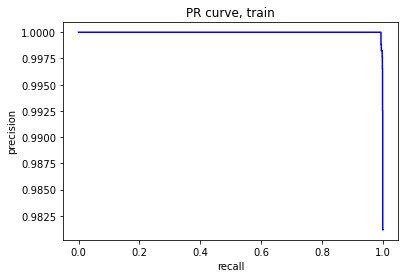

f1: 0.99 prec: 0.99 rec: 1.0 acc: 0.99 roc_auc 0.999974410546949
[[1688   17]
 [   1 1718]]

::: TEST PREDICTION :::

::: TP signal 4.2126
::::::::::b 150.58393962429136
Significance ::::: 0.3417075761531621
yes 0.3417075761531621
::: TP signal 4.1208
::::::::::b 203.28484082942924
Significance ::::: 0.2880524571650772
::: TP signal 3.9270000000000005
::::::::::b 230.71007357971257
Significance ::::: 0.25781163033500376
::: TP signal 3.7434000000000003
::::::::::b 254.04814918228152
Significance ::::: 0.23428628330399207
::: TP signal 3.6006
::::::::::b 271.07384767113683
Significance ::::: 0.21820960307384643
::: TP signal 3.4272
::::::::::b 280.82339763713605
Significance ::::: 0.20410000373956644
::: TP signal 3.0702
::::::::::b 292.1975459258414
Significance ::::: 0.17929595545683305
::: TP signal 2.703
::::::::::b 298.5943901872694
Significance ::::: 0.15618954368217916
::: TP signal 2.3153999999999995
::::::::::b 306.9766130055543
Significance ::::: 0.13198628351775432
::: TP sig

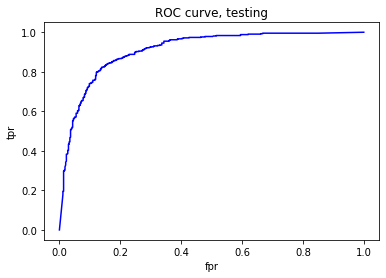

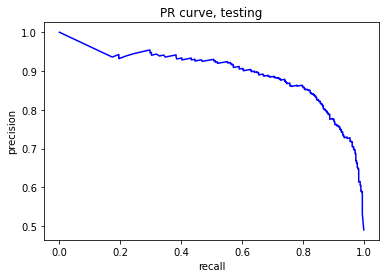

f1: 0.77 prec: 0.64 rec: 0.98 acc: 0.72 roc_auc 0.9103083796447642
[[203 234]
 [  7 413]]
[210.  47.  42.  28.  19.  20.  11.   8.  12.  10.   6.   8.   3.   7.
   6.] 
 [  7.   5.  17.  12.  14.  11.  10.  21.  22.  35.  19.  48.  29.  50.
 120.]


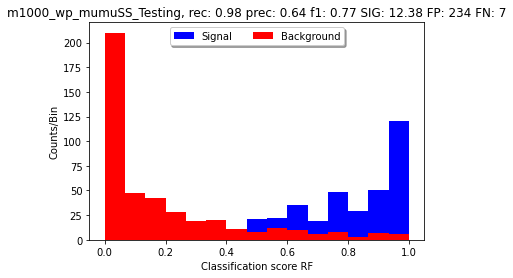

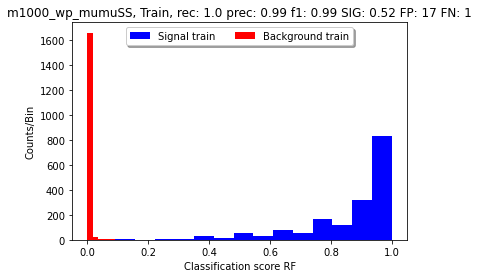

classification_report TEST ::::
              precision    recall  f1-score   support

           0       1.00      0.87      0.93 322.0909686421253
           1       0.08      0.80      0.14 4.284000000000044

    accuracy                           0.87 326.37496864212534
   macro avg       0.54      0.84      0.54 326.37496864212534
weighted avg       0.98      0.87      0.92 326.37496864212534

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       437
           1       0.86      0.80      0.83       420

    accuracy                           0.84       857
   macro avg       0.84      0.84      0.84       857
weighted avg       0.84      0.84      0.84       857

classification_report TRAIN ::::
              precision    recall  f1-score   support

           0       1.00      1.00      1.00 1257.640405961454
           1       1.00      0.95      0.97 17.533799999999754

    accuracy                           1.00 1275.17420596

,data,#background,#signal,% b,% s,total,w_s,w_b,%w_s,%w_b,w_total,SIGNIF_WEIGHT,SIGNIF_TRUE
0,train,1719,1931,47.095890,52.904110,3650,4.46061,1267.502985,0.350687,99.649313,1271.963595,0.125218,0.125218
1,test,423,490,46.330778,53.669222,913,1.13190,312.228389,0.361214,99.638786,313.360289,0.064019,0.064019


::: TP signal 5.59251
::::::::::b 1579.7313746035684
Running classification model ...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.2s finished


clf.classes_ [0 1]
1.4583899974822998

::: TRAIN PREDICTION :::

::: TP signal 4.44675
::::::::::b 1267.4245311982627
Significance ::::: 0.12483259615374201
yes 0.12483259615374201
::: TP signal 4.4328899999999996
::::::::::b 1267.502985483977
Significance ::::: 0.12443988691389173
::: TP signal 4.414409999999999
::::::::::b 1267.502985483977
Significance ::::: 0.12392141761963156
::: TP signal 4.388999999999999
::::::::::b 1267.502985483977
Significance ::::: 0.12320851823883894
::: TP signal 4.34742
::::::::::b 1267.502985483977
Significance ::::: 0.12204194537000522
::: TP signal 4.2735
::::::::::b 1267.502985483977
Significance ::::: 0.11996800665279904
::: TP signal 4.16262
::::::::::b 1267.502985483977
Significance ::::: 0.11685702321164954
::: TP signal 4.00554
::::::::::b 1267.502985483977
Significance ::::: 0.11244964184548739
::: TP signal 3.76068
::::::::::b 1267.502985483977
Significance ::::: 0.10557894998829918
::: TP signal 3.34488
::::::::::b 1267.502985483977
Significa

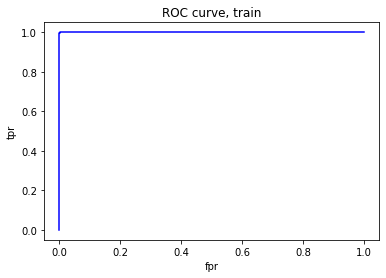

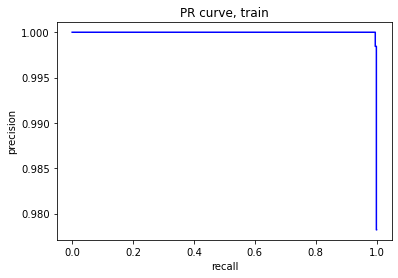

f1: 1.0 prec: 1.0 rec: 1.0 acc: 1.0 roc_auc 0.9999807193432285
[[1716    3]
 [   6 1925]]

::: TEST PREDICTION :::

::: TP signal 1.0949399999999998
::::::::::b 186.00466591682448
Significance ::::: 0.08020531477446076
yes 0.08020531477446076
::: TP signal 1.07415
::::::::::b 231.16666782872304
Significance ::::: 0.0705937919209598
::: TP signal 1.04412
::::::::::b 248.89546752657077
Significance ::::: 0.06613611794635703
::: TP signal 1.0164
::::::::::b 266.67376219045303
Significance ::::: 0.06220123161207307
::: TP signal 0.9771299999999998
::::::::::b 274.0161635850237
Significance ::::: 0.058993810674384
::: TP signal 0.93555
::::::::::b 279.6866349941662
Significance ::::: 0.05590997486117337
::: TP signal 0.88011
::::::::::b 289.5982363693078
Significance ::::: 0.05169151326699774
::: TP signal 0.80619
::::::::::b 295.8485134830214
Significance ::::: 0.04684957411203291
::: TP signal 0.72303
::::::::::b 301.7461577444495
Significance ::::: 0.04160659180142894
::: TP signal 0.609

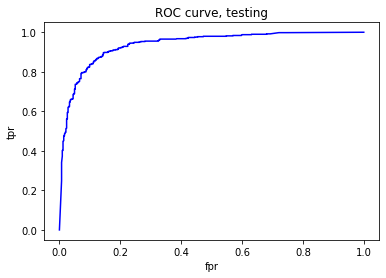

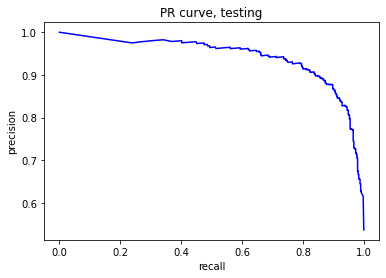

f1: 0.84 prec: 0.73 rec: 0.97 acc: 0.8 roc_auc 0.9378588314758527
[[252 171]
 [ 16 474]]
[254.  58.  14.  20.  15.  10.   5.  12.   5.   8.   3.   7.   2.   6.
   4.] 
 [ 16.   9.   5.  14.   6.  17.   8.  24.  10.  32.  16.  37.  32.  83.
 181.]


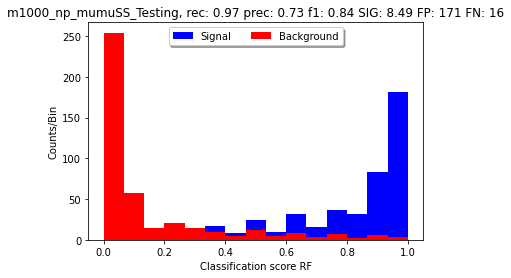

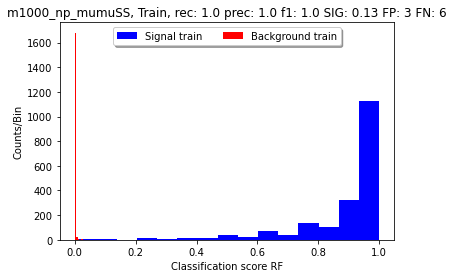

classification_report TEST ::::
              precision    recall  f1-score   support

           0       1.00      0.90      0.94 312.2283891195923
           1       0.03      0.83      0.05 1.1319000000000075

    accuracy                           0.90 313.3602891195923
   macro avg       0.51      0.86      0.50 313.3602891195923
weighted avg       1.00      0.90      0.94 313.3602891195923

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       423
           1       0.91      0.83      0.86       490

    accuracy                           0.86       913
   macro avg       0.86      0.86      0.86       913
weighted avg       0.87      0.86      0.86       913

classification_report TRAIN ::::
              precision    recall  f1-score   support

           0       1.00      1.00      1.00 1267.5029854839863
           1       1.00      0.96      0.98 4.460609999999968

    accuracy                           1.00 1271.9635954839

,data,#background,#signal,% b,% s,total,w_s,w_b,%w_s,%w_b,w_total,SIGNIF_WEIGHT,SIGNIF_TRUE
0,train,1720,1072,61.604585,38.395415,2792,39.2352,1265.280696,3.007644,96.992356,1304.515896,1.097389,1.097389
1,test,422,277,60.371960,39.628040,699,10.1382,314.450679,3.123397,96.876603,324.588879,0.568690,0.568690


::: TP signal 49.37340000000001
::::::::::b 1579.7313746035684
Running classification model ...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.8s finished


clf.classes_ [0 1]
0.967566967010498

::: TRAIN PREDICTION :::

::: TP signal 39.235200000000006
::::::::::b 1255.4706271488535
Significance ::::: 1.1016248813938512
yes 1.1016248813938512
::: TP signal 39.198600000000006
::::::::::b 1264.2680800059966
Significance ::::: 1.0968054202557447
::: TP signal 38.942400000000006
::::::::::b 1264.9626871488535
Significance ::::: 1.0893766108496963
::: TP signal 38.50320000000001
::::::::::b 1265.228392863139
Significance ::::: 1.0770395102194246
::: TP signal 37.4418
::::::::::b 1265.228392863139
Significance ::::: 1.0474928401311747
::: TP signal 35.7216
::::::::::b 1265.2545442917108
Significance ::::: 0.9995795335887135
::: TP signal 32.610600000000005
::::::::::b 1265.280695720282
Significance ::::: 0.9128840643503922
::: TP signal 27.669600000000003
::::::::::b 1265.280695720282
Significance ::::: 0.7750647169019036
::: TP signal 20.496000000000002
::::::::::b 1265.280695720282
Significance ::::: 0.5746579826483911
::: TP signal 11.968200

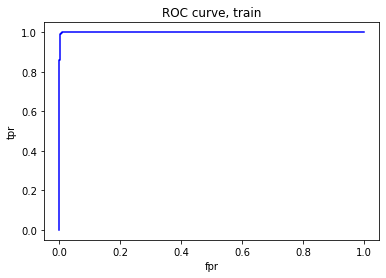

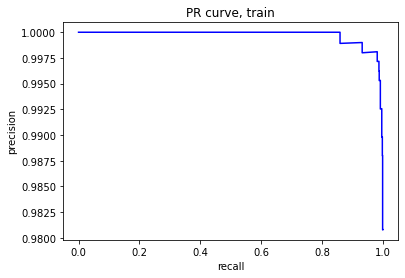

f1: 0.97 prec: 0.94 rec: 1.0 acc: 0.98 roc_auc 0.9998253644567858
[[1652   68]
 [   0 1072]]

::: TEST PREDICTION :::

::: TP signal 9.4794
::::::::::b 63.58957040075392
Significance ::::: 1.16090439424958
yes 1.16090439424958
::: TP signal 8.6376
::::::::::b 133.59376843688216
Significance ::::: 0.7394651428056478
::: TP signal 7.832400000000002
::::::::::b 182.40639108516325
Significance ::::: 0.5758512563787093
::: TP signal 6.514800000000001
::::::::::b 222.49806497643743
Significance ::::: 0.43464928965796146
::: TP signal 4.941
::::::::::b 254.75704769272002
Significance ::::: 0.3085722618816734
::: TP signal 3.916200000000001
::::::::::b 273.4223104770041
Significance ::::: 0.23627407761346728
::: TP signal 2.7084
::::::::::b 289.32176185214576
Significance ::::: 0.15898156664662594
::: TP signal 1.6103999999999998
::::::::::b 297.7369289658594
Significance ::::: 0.09324522718687796
::: TP signal 0.7319999999999999
::::::::::b 309.8953160455724
Significance ::::: 0.0415654738476

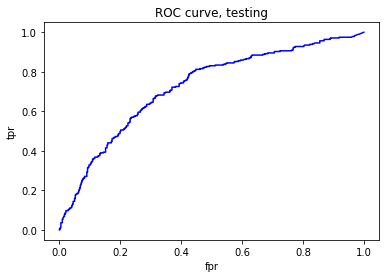

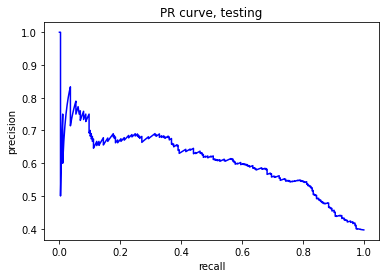

f1: 0.59 prec: 0.43 rec: 0.94 acc: 0.49 roc_auc 0.7209694252912895
[[ 82 340]
 [ 18 259]]
[104.  59.  51.  36.  30.  41.  21.  18.  21.  10.   9.   9.   8.   3.
   2.] 
 [26. 11. 11. 23. 17. 31. 27. 22. 21. 19. 22. 19. 12. 12.  4.]


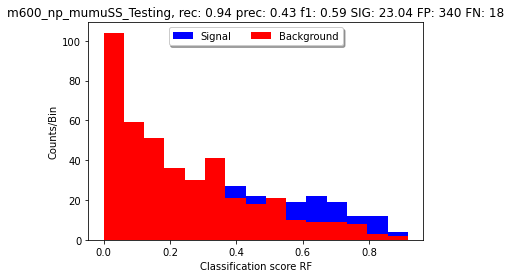

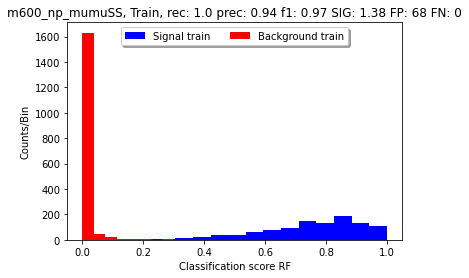

classification_report TEST ::::
              precision    recall  f1-score   support

           0       0.98      0.87      0.92 314.4506788832874
           1       0.09      0.39      0.14 10.138199999999992

    accuracy                           0.85 324.5888788832874
   macro avg       0.53      0.63      0.53 324.5888788832874
weighted avg       0.95      0.85      0.90 324.5888788832874

              precision    recall  f1-score   support

           0       0.68      0.87      0.76       422
           1       0.66      0.39      0.49       277

    accuracy                           0.68       699
   macro avg       0.67      0.63      0.63       699
weighted avg       0.67      0.68      0.65       699

classification_report TRAIN ::::
              precision    recall  f1-score   support

           0       1.00      1.00      1.00 1265.2806957202924
           1       1.00      0.91      0.95 39.23519999999997

    accuracy                           1.00 1304.5158957202

,data,#background,#signal,% b,% s,total,w_s,w_b,%w_s,%w_b,w_total,SIGNIF_WEIGHT,SIGNIF_TRUE
0,train,1729,1343,56.282552,43.717448,3072,33.8436,1278.470232,2.578926,97.421074,1312.313832,0.942393,0.942393
1,test,413,355,53.776042,46.223958,768,8.9460,301.261142,2.883879,97.116121,310.207142,0.512895,0.512895


::: TP signal 42.78959999999999
::::::::::b 1579.7313746035684
Running classification model ...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.8s finished


clf.classes_ [0 1]
0.9293918609619141

::: TRAIN PREDICTION :::

::: TP signal 33.843599999999995
::::::::::b 1274.9566194017625
Significance ::::: 0.9436788883335215
yes 0.9436788883335215
::: TP signal 33.7932
::::::::::b 1277.938820830334
Significance ::::: 0.9411890985364794
::: TP signal 33.516
::::::::::b 1278.3656265446195
Significance ::::: 0.9333473398468859
::: TP signal 33.1884
::::::::::b 1278.391777973191
Significance ::::: 0.9242538247261801
::: TP signal 32.5584
::::::::::b 1278.4179294017626
Significance ::::: 0.9067731689089662
::: TP signal 31.4496
::::::::::b 1278.4702322589053
Significance ::::: 0.8759991231102696
::: TP signal 29.4084
::::::::::b 1278.4702322589053
Significance ::::: 0.8193580156228201
::: TP signal 26.510399999999997
::::::::::b 1278.4702322589053
Significance ::::: 0.7388908901792106
::: TP signal 22.4784
::::::::::b 1278.4702322589053
Significance ::::: 0.6268372990935512
::: TP signal 17.6652
::::::::::b 1278.4702322589053
Significance ::::: 0.

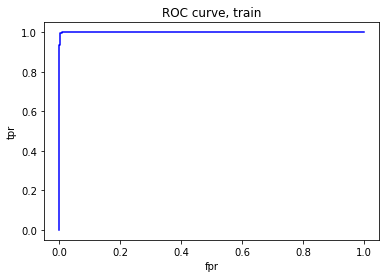

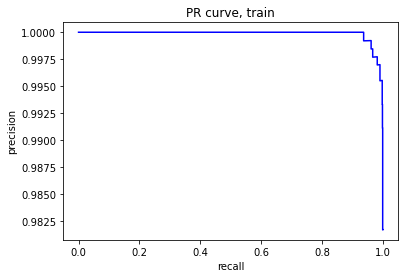

f1: 0.99 prec: 0.97 rec: 1.0 acc: 0.99 roc_auc 0.9998875991743491
[[1693   36]
 [   0 1343]]

::: TEST PREDICTION :::

::: TP signal 8.5932
::::::::::b 108.97172075241082
Significance ::::: 0.8127077671938783
yes 0.8127077671938783
::: TP signal 8.0136
::::::::::b 170.44329335211938
Significance ::::: 0.6090972560423794
::: TP signal 7.2576
::::::::::b 201.14834870596582
Significance ::::: 0.5086909578816259
::: TP signal 6.4512
::::::::::b 227.5895643085347
Significance ::::: 0.4256294883685671
::: TP signal 5.7204
::::::::::b 242.83761258266824
Significance ::::: 0.3656592593571507
::: TP signal 5.0652
::::::::::b 259.27581681009553
Significance ::::: 0.31355277645894297
::: TP signal 4.3595999999999995
::::::::::b 276.48084244666524
Significance ::::: 0.2615042394265221
::: TP signal 3.4524
::::::::::b 283.24093956037893
Significance ::::: 0.20472194266980917
::: TP signal 2.7215999999999996
::::::::::b 292.3599623786637
Significance ::::: 0.15892551061445054
::: TP signal 1.8144
::

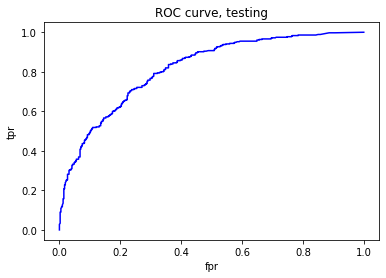

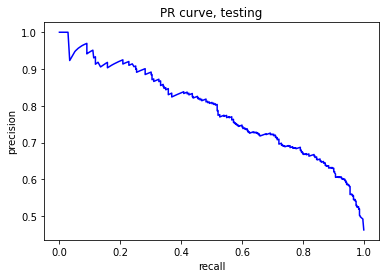

f1: 0.71 prec: 0.56 rec: 0.96 acc: 0.63 roc_auc 0.8162670940899636
[[144 269]
 [ 14 341]]
[161.  46.  53.  20.  26.  15.  15.  16.  16.  11.   8.  11.   8.   2.
   5.] 
 [16. 18. 24. 21. 24. 20. 20. 17. 24. 26. 24. 31. 19. 39. 32.]


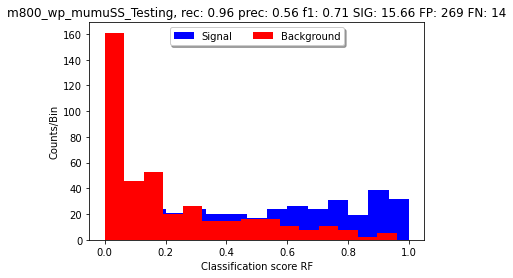

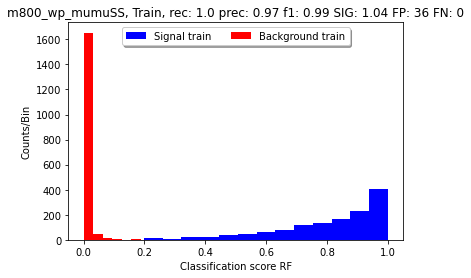

classification_report TEST ::::
              precision    recall  f1-score   support

           0       0.99      0.86      0.92 301.26114234466405
           1       0.11      0.57      0.18 8.945999999999966

    accuracy                           0.85 310.207142344664
   macro avg       0.55      0.71      0.55 310.207142344664
weighted avg       0.96      0.85      0.90 310.207142344664

              precision    recall  f1-score   support

           0       0.69      0.85      0.76       413
           1       0.76      0.57      0.65       355

    accuracy                           0.72       768
   macro avg       0.73      0.71      0.71       768
weighted avg       0.73      0.72      0.71       768

classification_report TRAIN ::::
              precision    recall  f1-score   support

           0       1.00      1.00      1.00 1278.470232258916
           1       1.00      0.93      0.96 33.843600000000855

    accuracy                           1.00 1312.3138322589168

In [4]:
data_files = glob(f"{source_path}/all_signal*.csv")
l=[]

for i in data_files:
    print("*"*60)
    print("*"*60)
    print("*"*60)
    print("File: "+ i.split("/")[-1])
    signal = i.split("/")[-1].split("_")[-3] + "_" + i.split("/")[-1].split("_")[-2] 
    print(signal)
    metrics, mask_sig, mask_back, y_pred, y_test, y_pred_score, y_pred_train, y_pred_score_train,mask_sig_train, mask_back_train, new_l = run(i,signal, category="mumuSS")
    metrics["signal"] = signal
    l.append(metrics)
    print("*"*20)
    
df_metrics = pd.DataFrame(l)
df_new = pd.DataFrame(new_l)

In [ ]:
df_metrics

In [ ]:
df_new